In [4]:
!python -m pip 3.8

ERROR: unknown command "3.8"


In [1]:
#import data_preprocess_functions as dp_f
import argparse, configparser
import re
import ast
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
analysis='resolved'
channel='ggF'
PreselectionCuts=''
samples=['Zjets','Wjets','stop','Diboson','ttbar','Radion','VBFRSG','RSG','VBFRadion','VBFHVTWZ']

### Reading from config file
config = configparser.ConfigParser()
config.read('MyConfig.txt')
inputFiles = ast.literal_eval(config.get('config', 'inputFiles'))
dataType = ast.literal_eval(config.get('config', 'dataType'))
rootBranchSubSample = ast.literal_eval(config.get('config', 'rootBranchSubSample'))
dfPath = config.get('config', 'dfPath')

#list of files under dfPath
files=os.listdir(dfPath)
#InputFeaturesResolved for 'resolved' analysis --> make it dyn
dataVariables=ast.literal_eval(config.get('config', 'InputFeaturesResolved'))

In [3]:
dataVariables,samples

(['lep1_m',
  'lep1_pt',
  'lep1_eta',
  'lep1_phi',
  'lep2_m',
  'lep2_pt',
  'lep2_eta',
  'lep2_phi',
  'Zcand_m',
  'Zcand_pt',
  'Wdijet_m',
  'Wdijet_pt',
  'Wdijet_eta',
  'Wdijet_phi',
  'Zdijet_m',
  'Zdijet_pt',
  'Zdijet_eta',
  'Zdijet_phi',
  'sigWJ1_m',
  'sigWJ1_pt',
  'sigWJ1_eta',
  'sigWJ1_phi',
  'sigWJ2_m',
  'sigWJ2_pt',
  'sigWJ2_eta',
  'sigWJ2_phi',
  'sigZJ1_m',
  'sigZJ1_pt',
  'sigZJ1_eta',
  'sigZJ1_phi',
  'sigZJ2_m',
  'sigZJ2_pt',
  'sigZJ2_eta',
  'sigZJ2_phi',
  'NJets',
  'DSID'],
 ['Zjets',
  'Wjets',
  'stop',
  'Diboson',
  'ttbar',
  'Radion',
  'VBFRSG',
  'RSG',
  'VBFRadion',
  'VBFHVTWZ'])

In [8]:
print(dfPath+'MixData_PD_'+analysis+'_'+channel+'.pkl')
!python --version
!pip install pickle5

/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/MixData_PD_resolved_ggF.pkl
Python 3.7.3
     |████████████████████████████████| 133kB 2.7MB/s eta 0:00:01
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=122790 sha256=3f87edf2f2a5fc894962eeb0fc40ddbf01d09a704dafb5855df3383034092a17
  Stored in directory: /afs/le.infn.it/user/c/centonze/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [9]:
import pickle5 as pickle
with open(dfPath+'MixData_PD_'+analysis+'_'+channel+'.pkl', "rb") as fh:
      mixed_data = pickle.load(fh)

In [13]:
mixed_data=pd.read_pickle(dfPath+'MixData_PD_'+analysis+'_'+channel+'.pkl')

ValueError: unsupported pickle protocol: 5

In [12]:
mixed_data

AttributeError: 'NoneType' object has no attribute 'axes'

In [31]:
#select variables of interest
pre_inputvariables=dataVariables
pre_inputvariables.append('origin')
mixed_data_cut=mixed_data_cut[pre_inputvariables]

In [241]:
pre_inputvariables

['lep1_m',
 'lep1_pt',
 'lep1_eta',
 'lep1_phi',
 'lep2_m',
 'lep2_pt',
 'lep2_eta',
 'lep2_phi',
 'Zcand_m',
 'Zcand_pt',
 'Wdijet_m',
 'Wdijet_pt',
 'Wdijet_eta',
 'Wdijet_phi',
 'Zdijet_m',
 'Zdijet_pt',
 'Zdijet_eta',
 'Zdijet_phi',
 'sigWJ1_m',
 'sigWJ1_pt',
 'sigWJ1_eta',
 'sigWJ1_phi',
 'sigWJ2_m',
 'sigWJ2_pt',
 'sigWJ2_eta',
 'sigWJ2_phi',
 'sigZJ1_m',
 'sigZJ1_pt',
 'sigZJ1_eta',
 'sigZJ1_phi',
 'sigZJ2_m',
 'sigZJ2_pt',
 'sigZJ2_eta',
 'sigZJ2_phi',
 'NJets',
 'DSID',
 'origin']

In [32]:
#select signal
signal=samples[-3]
signal

'RSG'

In [33]:
training_samples=samples[:5]
training_samples.append(signal)
training_samples

['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'RSG']

In [74]:
q_string=''
for k in range(0,len(training_samples)):
    q_string+='origin.str.match("'+training_samples[k]+'") or '
q_string=q_string[:-4]

data_set=mixed_data_cut.query(q_string, engine='python')

In [75]:
data_set

,lep1_m,lep1_pt,lep1_eta,lep1_phi,lep2_m,lep2_pt,lep2_eta,lep2_phi,Zcand_m,Zcand_pt,...,sigZJ1_pt,sigZJ1_eta,sigZJ1_phi,sigZJ2_m,sigZJ2_pt,sigZJ2_eta,sigZJ2_phi,NJets,DSID,origin
0,0.105658,77.407974,-1.029867,0.822505,0.105658,61.557640,-0.522145,2.039026,86.481270,114.400330,...,43.951756,0.064974,-2.806025,4.174513,34.286308,0.174289,-2.120107,3,5000,Diboson
1,0.000511,45.498417,0.547872,1.665218,0.000511,31.308121,-0.631870,-1.727976,88.496490,17.060585,...,53.098415,1.688531,0.253756,7.736113,50.014011,1.179579,-2.664497,3,1000,Diboson
2,0.105658,58.545914,-1.106456,-3.003222,0.105658,34.733532,0.255444,1.864972,88.475349,72.561302,...,70.835678,1.605654,-0.377110,7.895816,59.805733,0.081164,-0.241247,3,700,Diboson
3,0.000511,53.691601,0.565192,-1.599588,0.000511,37.826031,0.237518,1.273353,90.543251,19.935347,...,40.114872,1.920856,-2.778975,3.561456,30.133196,1.065547,0.844032,3,1000,Diboson
4,0.000511,67.468414,-1.740101,-0.676910,0.000511,39.700340,-1.229977,-2.739783,92.737686,59.976093,...,57.284790,-1.762087,2.230432,6.057406,53.398308,-1.530911,-0.262131,2,5000,Diboson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17725824,0.000511,802.914612,0.721265,-0.260793,0.000511,280.091431,0.797046,-0.079407,93.117798,1079.593994,...,855.603943,-0.912761,3.045089,53.699699,406.157959,-1.724077,2.455393,6,3000,RSG
17725825,0.000511,702.229187,-1.156972,1.891525,0.000511,247.647751,-1.177884,2.121720,96.179924,945.035278,...,855.258179,-0.038553,-1.283011,6.477614,60.618317,0.987557,-0.511293,4,5000,RSG
17725826,0.000511,594.569397,0.474760,-2.621913,0.000511,168.765579,0.607334,-2.883370,92.664162,758.854309,...,893.394592,-1.422049,0.539712,9.604809,113.304329,-1.234100,-2.199081,4,700,RSG
17725827,0.105658,551.253662,-0.401856,0.933192,0.105658,409.695251,-0.614352,0.976628,103.259163,960.727234,...,1064.851196,1.276785,-2.003692,10.459124,77.491219,2.094906,1.892023,4,700,RSG


In [84]:
import makeplots as mkplots

def find(str_jets,df):
    n=0
    for i in df['origin']==str_jets:
        if i==True:
            n+=1
    return n
    
    

def composition_plot(df,df_str,samples):
    x=np.array([])
    for var in samples:
        x=np.append(x,find(var,df))

    plt.figure(1,figsize=(18,6))
    plt.bar(samples,x)
    #plt.text(3, 80, analysis+' '+channel , fontsize=12,horizontalalignment='center',verticalalignment='center')
    plt.suptitle(analysis+' '+channel+' composition')
    plt.yscale('log')
#    plt.savefig(path+directory+'/'+analysis+'_'+channel+'_'+df_str+'_composition.pdf')
    plt.show()
    return x,samples
    

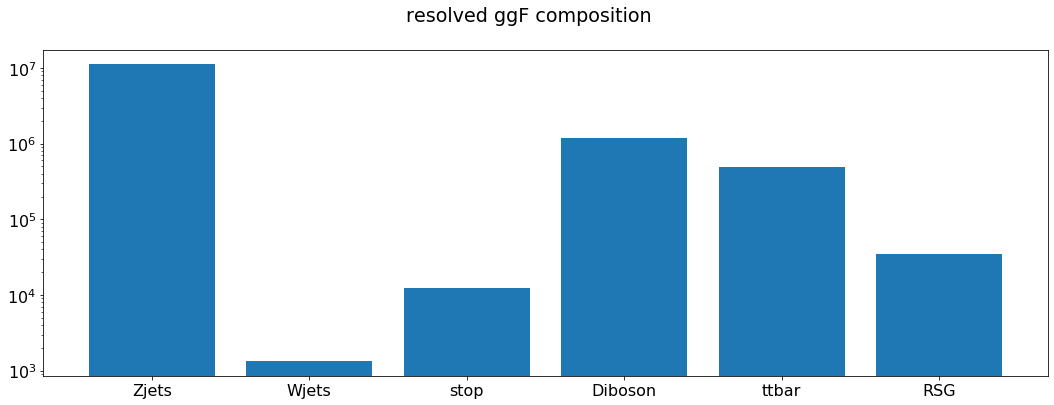

In [85]:
composition=composition_plot(data_set,'data_set',training_samples)

In [86]:
composition

(array([1.1121103e+07, 1.3450000e+03, 1.2403000e+04, 1.1925400e+06,
        4.9262800e+05, 3.4842000e+04]),
 ['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'RSG'])

In [231]:
q_v=[0.1,0.1,0.1,0.1,0.1]
q_v.append(1-sum(q_v))
q=np.array(q_v)
print(np.sum(q))


N_entries=sum(composition[0])
p=np.array(composition[0]/N_entries)

N_v=p[np.argsort(p)]/q[np.argsort(p)]
N_v=N_v[np.argsort(N_v)]
N_prime_tot=int(N_entries*N_v[0])
composition_q=[int(q[n]*N_prime_tot) for n in range(0,len(p))]

q=np.array(composition_q)/N_prime_tot
if (composition_q<=N_entries).all():
    print('True')
    print(N_prime_tot)
    print(N_prime_tot/N_entries)
    print(q)
    print(composition_q)

1.0
True
13449
0.0010462190139589997
[0.09993308 0.09993308 0.09993308 0.09993308 0.09993308 0.49996282]
[1344, 1344, 1344, 1344, 1344, 6724]


In [238]:
k=0
reweighted_dataset=pd.concat(data_set.query('origin.str.match("'+training_samples[k]+'")').sample(frac=1)[:composition_q[k]] for k in range(0,len(training_samples)))
reweighted_dataset

,lep1_m,lep1_pt,lep1_eta,lep1_phi,lep2_m,lep2_pt,lep2_eta,lep2_phi,Zcand_m,Zcand_pt,...,sigZJ1_pt,sigZJ1_eta,sigZJ1_phi,sigZJ2_m,sigZJ2_pt,sigZJ2_eta,sigZJ2_phi,NJets,DSID,origin
6576668,0.105658,44.605743,-0.322610,0.406563,0.105658,34.324436,-1.650673,2.682390,90.377174,34.400597,...,68.156509,0.196246,2.521338,5.506869,40.662796,0.678911,-0.900189,3,5000,Zjets
5613978,0.105658,61.578297,0.061104,-2.847462,0.105658,32.013653,-0.215833,0.843582,86.355499,38.136459,...,73.156151,-0.681072,-0.335746,6.336687,45.367699,-1.048848,2.835499,3,3000,Zjets
4380112,0.105658,38.599510,1.150275,2.055601,0.105658,38.336281,-0.395267,-0.063471,93.802597,37.643608,...,60.404015,-0.880054,-0.017840,4.878094,32.322441,2.333616,-2.772855,3,3000,Zjets
8980422,0.105658,46.424950,-0.919348,3.035735,0.105658,40.152596,0.332141,-1.495545,87.868179,55.641613,...,226.858231,2.196388,1.808250,17.216509,175.383438,-0.002854,-1.330260,3,700,Zjets
12133651,0.000511,60.567471,-0.893406,0.521741,0.000511,37.632915,0.748358,1.002000,90.385178,95.538567,...,78.056465,-2.194700,-1.695744,6.299845,58.275612,0.747393,2.575180,3,1000,Zjets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17706321,0.000511,144.206085,1.771801,1.780796,0.000511,66.776276,0.848616,1.852194,94.104897,210.866043,...,461.853729,-0.061137,-0.353953,24.019043,328.404083,0.065172,-3.065060,4,700,RSG
17695573,0.000511,261.024200,-0.533064,-3.071756,0.000511,202.418335,-0.651583,2.831951,90.888756,455.259552,...,262.878479,-1.648013,-0.653145,10.706184,160.302338,-0.662848,0.801482,4,3000,RSG
17701719,0.105658,246.822708,1.808117,0.970210,0.105658,88.252914,1.413939,0.488593,91.566231,327.597229,...,166.564209,0.103226,-1.978540,28.558136,141.586304,-0.314271,-3.047304,3,1000,RSG
17713152,0.000511,529.458496,-0.170939,1.595448,0.000511,265.503845,-0.420454,1.529496,96.997658,794.577820,...,377.270782,-0.319762,-1.654362,16.037819,117.573723,1.372032,-2.296677,6,700,RSG


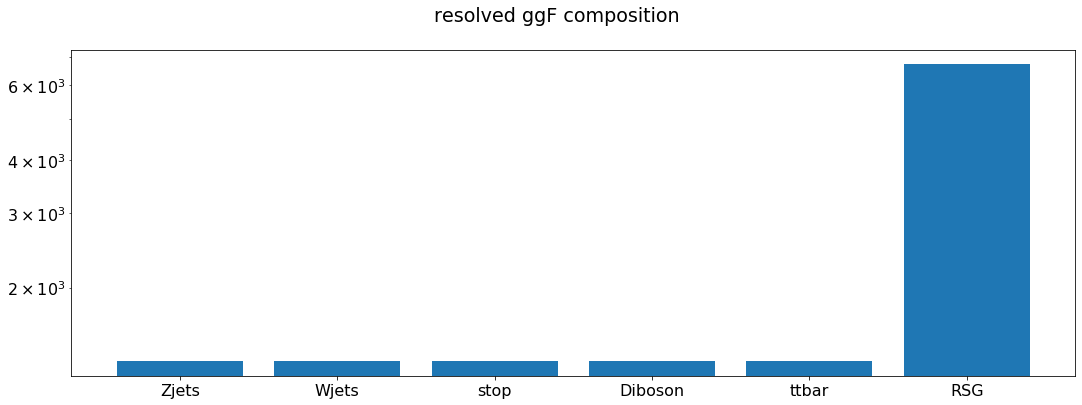

In [239]:
reweighted_dataset_composition=composition_plot(reweighted_dataset,'data_set',training_samples)

In [252]:
reweighted_dataset.to_pickle(dfPath + 'MixData_PD_' + analysis + '_' + channel + 'cut_reweighted_dataset_05unifbkg-05sig.pkl')

In [250]:
import makeplots as mkplots
def plot_var(list_var,samples,var_str,plt_str,path,directory):
    fig=plt.figure(figsize=(16,8))
    #for l in range(0,len(list_var)):
    plt.hist(list_var,label=samples,bins=100,stacked=True,alpha=0.8)

    plt.title(directory)
    plt.yscale('log')
    plt.xlabel(var_str)
    plt.legend()
#    plt.savefig(path+directory+'/'+var_str+'_'+plt_str+'.pdf')
#    plt.close(fig)
    plt.show()

lep1_m
Sampling lep1_m in Zjets
Created  lep1_m  array for  Zjets collection
Sampling lep1_m in Wjets
Created  lep1_m  array for  Wjets collection
Sampling lep1_m in stop
Created  lep1_m  array for  stop collection
Sampling lep1_m in Diboson
Created  lep1_m  array for  Diboson collection
Sampling lep1_m in ttbar
Created  lep1_m  array for  ttbar collection
Sampling lep1_m in RSG
Created  lep1_m  array for  RSG collection
Done


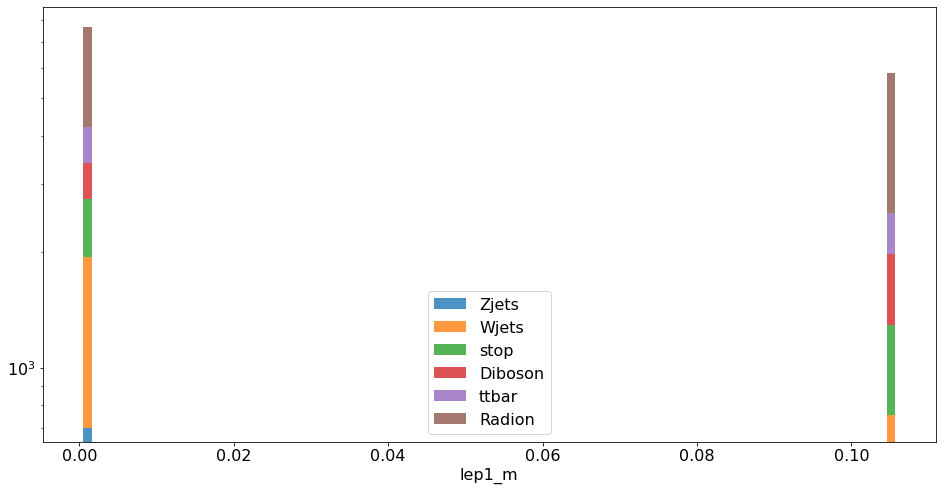

lep1_pt
Sampling lep1_pt in Zjets
Created  lep1_pt  array for  Zjets collection
Sampling lep1_pt in Wjets
Created  lep1_pt  array for  Wjets collection
Sampling lep1_pt in stop
Created  lep1_pt  array for  stop collection
Sampling lep1_pt in Diboson
Created  lep1_pt  array for  Diboson collection
Sampling lep1_pt in ttbar
Created  lep1_pt  array for  ttbar collection
Sampling lep1_pt in RSG
Created  lep1_pt  array for  RSG collection
Done


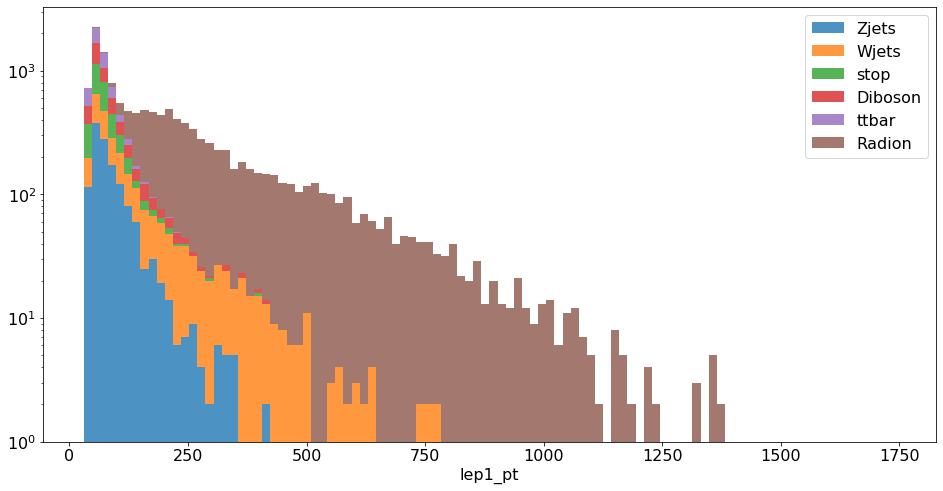

lep1_eta
Sampling lep1_eta in Zjets
Created  lep1_eta  array for  Zjets collection
Sampling lep1_eta in Wjets
Created  lep1_eta  array for  Wjets collection
Sampling lep1_eta in stop
Created  lep1_eta  array for  stop collection
Sampling lep1_eta in Diboson
Created  lep1_eta  array for  Diboson collection
Sampling lep1_eta in ttbar
Created  lep1_eta  array for  ttbar collection
Sampling lep1_eta in RSG
Created  lep1_eta  array for  RSG collection
Done


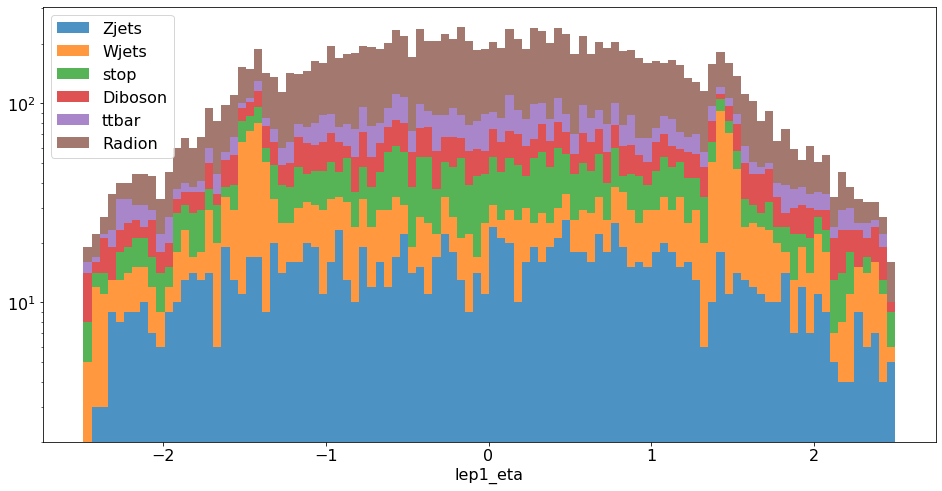

lep1_phi
Sampling lep1_phi in Zjets
Created  lep1_phi  array for  Zjets collection
Sampling lep1_phi in Wjets
Created  lep1_phi  array for  Wjets collection
Sampling lep1_phi in stop
Created  lep1_phi  array for  stop collection
Sampling lep1_phi in Diboson
Created  lep1_phi  array for  Diboson collection
Sampling lep1_phi in ttbar
Created  lep1_phi  array for  ttbar collection
Sampling lep1_phi in RSG
Created  lep1_phi  array for  RSG collection
Done


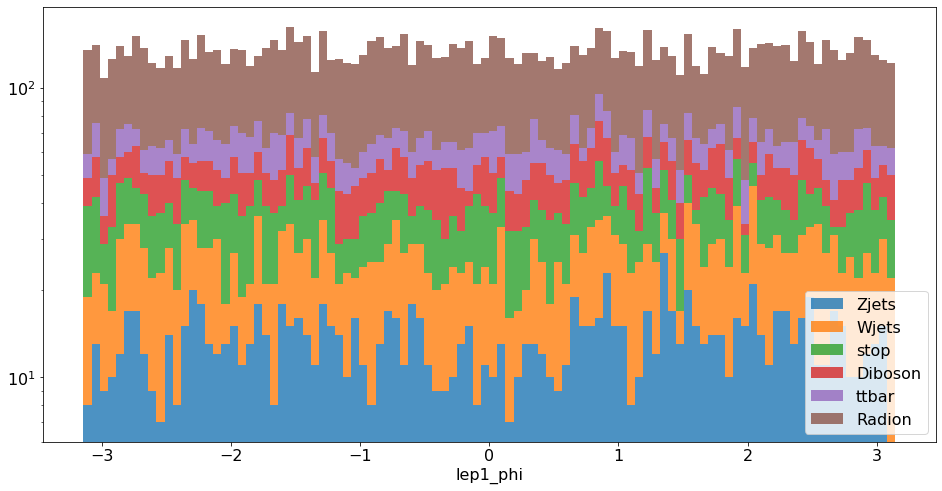

lep2_m
Sampling lep2_m in Zjets
Created  lep2_m  array for  Zjets collection
Sampling lep2_m in Wjets
Created  lep2_m  array for  Wjets collection
Sampling lep2_m in stop
Created  lep2_m  array for  stop collection
Sampling lep2_m in Diboson
Created  lep2_m  array for  Diboson collection
Sampling lep2_m in ttbar
Created  lep2_m  array for  ttbar collection
Sampling lep2_m in RSG
Created  lep2_m  array for  RSG collection
Done


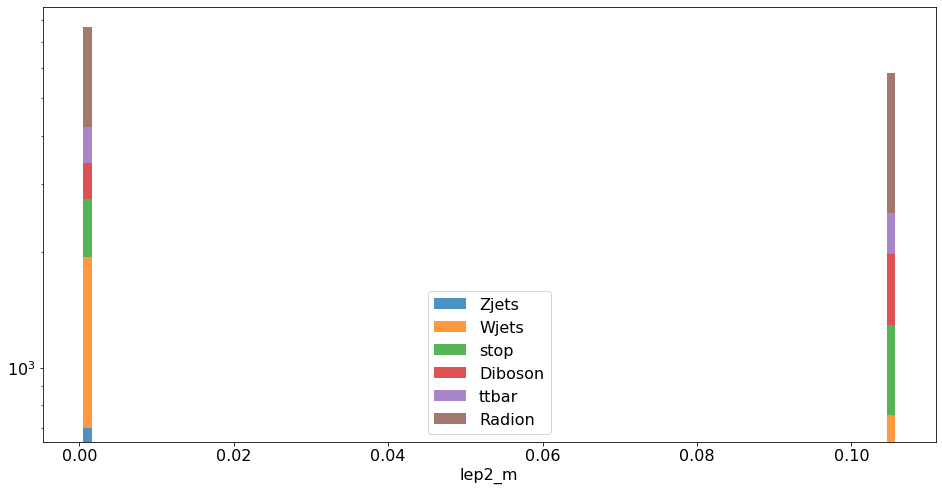

lep2_pt
Sampling lep2_pt in Zjets
Created  lep2_pt  array for  Zjets collection
Sampling lep2_pt in Wjets
Created  lep2_pt  array for  Wjets collection
Sampling lep2_pt in stop
Created  lep2_pt  array for  stop collection
Sampling lep2_pt in Diboson
Created  lep2_pt  array for  Diboson collection
Sampling lep2_pt in ttbar
Created  lep2_pt  array for  ttbar collection
Sampling lep2_pt in RSG
Created  lep2_pt  array for  RSG collection
Done


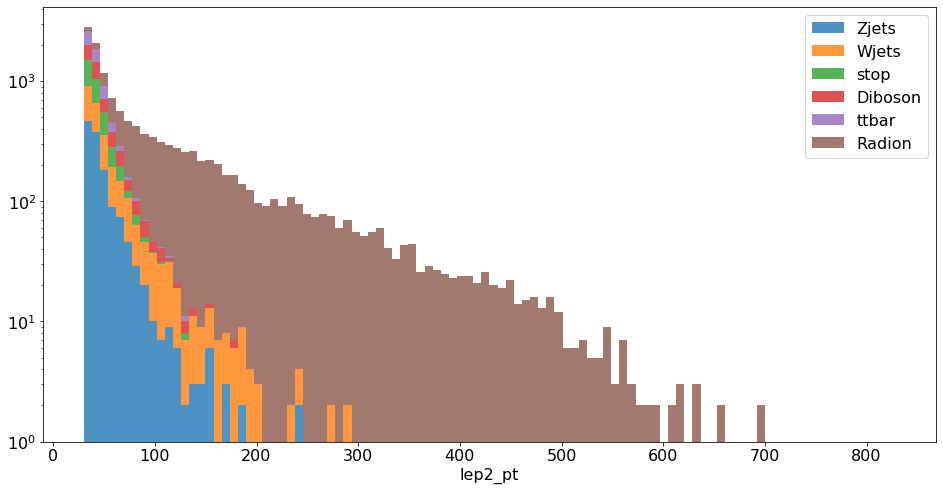

lep2_eta
Sampling lep2_eta in Zjets
Created  lep2_eta  array for  Zjets collection
Sampling lep2_eta in Wjets
Created  lep2_eta  array for  Wjets collection
Sampling lep2_eta in stop
Created  lep2_eta  array for  stop collection
Sampling lep2_eta in Diboson
Created  lep2_eta  array for  Diboson collection
Sampling lep2_eta in ttbar
Created  lep2_eta  array for  ttbar collection
Sampling lep2_eta in RSG
Created  lep2_eta  array for  RSG collection
Done


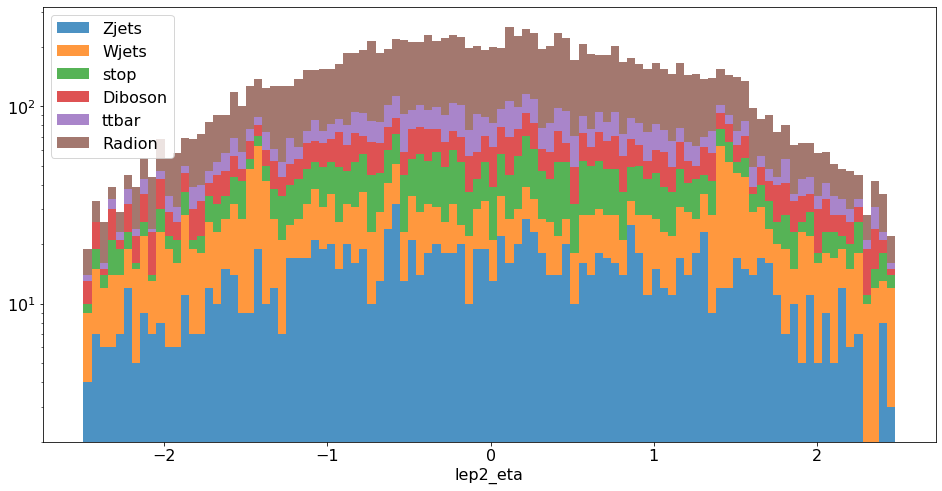

lep2_phi
Sampling lep2_phi in Zjets
Created  lep2_phi  array for  Zjets collection
Sampling lep2_phi in Wjets
Created  lep2_phi  array for  Wjets collection
Sampling lep2_phi in stop
Created  lep2_phi  array for  stop collection
Sampling lep2_phi in Diboson
Created  lep2_phi  array for  Diboson collection
Sampling lep2_phi in ttbar
Created  lep2_phi  array for  ttbar collection
Sampling lep2_phi in RSG
Created  lep2_phi  array for  RSG collection
Done


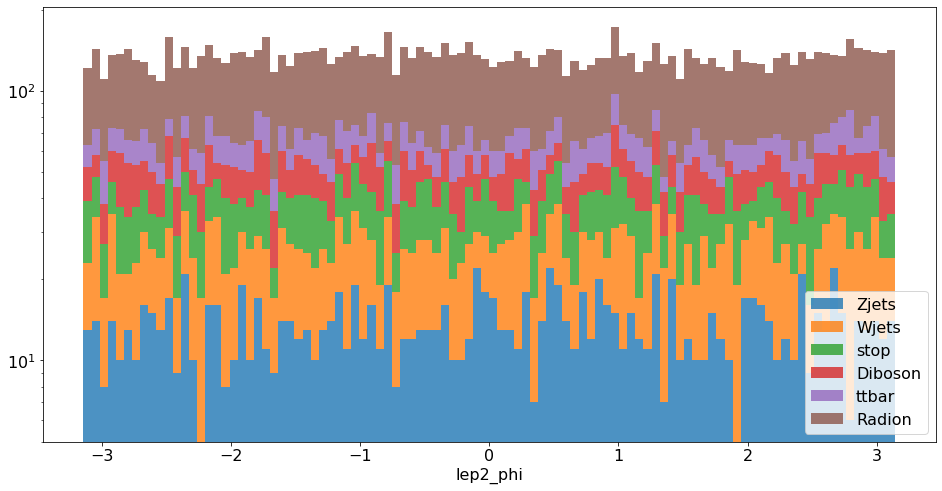

Zcand_m
Sampling Zcand_m in Zjets
Created  Zcand_m  array for  Zjets collection
Sampling Zcand_m in Wjets
Created  Zcand_m  array for  Wjets collection
Sampling Zcand_m in stop
Created  Zcand_m  array for  stop collection
Sampling Zcand_m in Diboson
Created  Zcand_m  array for  Diboson collection
Sampling Zcand_m in ttbar
Created  Zcand_m  array for  ttbar collection
Sampling Zcand_m in RSG
Created  Zcand_m  array for  RSG collection
Done


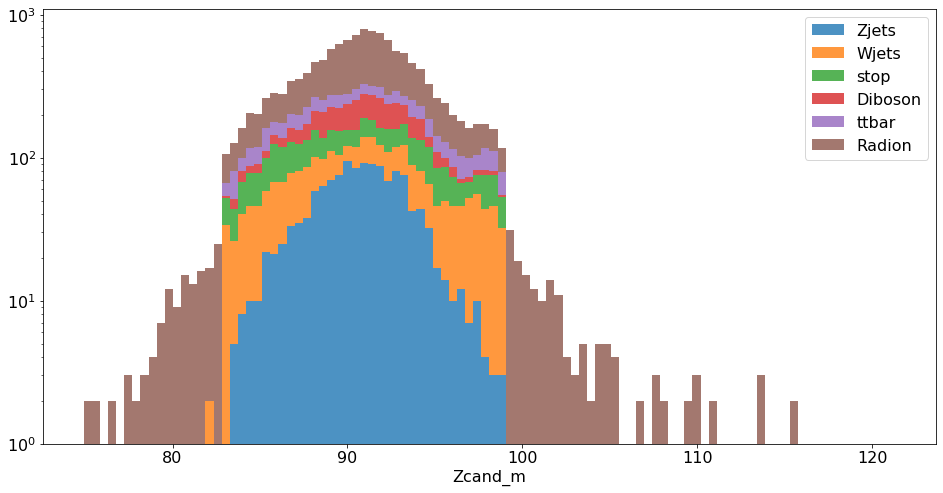

Zcand_pt
Sampling Zcand_pt in Zjets
Created  Zcand_pt  array for  Zjets collection
Sampling Zcand_pt in Wjets
Created  Zcand_pt  array for  Wjets collection
Sampling Zcand_pt in stop
Created  Zcand_pt  array for  stop collection
Sampling Zcand_pt in Diboson
Created  Zcand_pt  array for  Diboson collection
Sampling Zcand_pt in ttbar
Created  Zcand_pt  array for  ttbar collection
Sampling Zcand_pt in RSG
Created  Zcand_pt  array for  RSG collection
Done


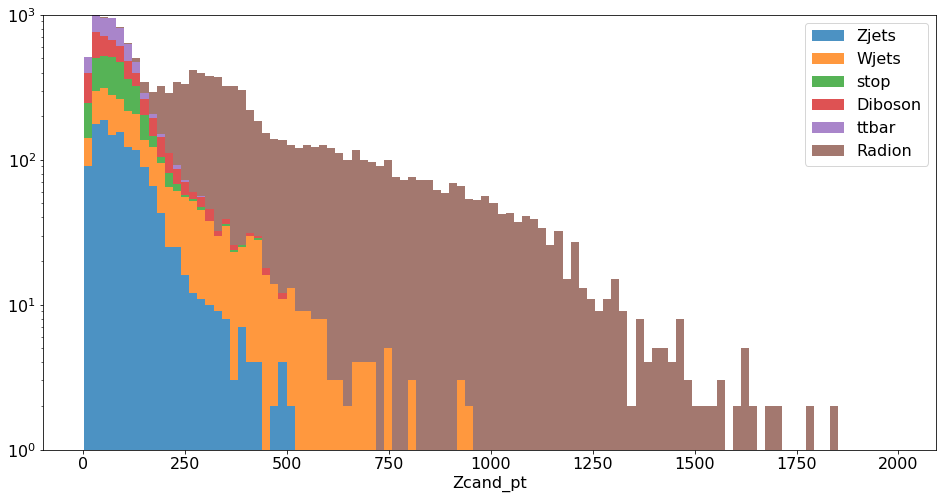

Wdijet_m
Sampling Wdijet_m in Zjets
Created  Wdijet_m  array for  Zjets collection
Sampling Wdijet_m in Wjets
Created  Wdijet_m  array for  Wjets collection
Sampling Wdijet_m in stop
Created  Wdijet_m  array for  stop collection
Sampling Wdijet_m in Diboson
Created  Wdijet_m  array for  Diboson collection
Sampling Wdijet_m in ttbar
Created  Wdijet_m  array for  ttbar collection
Sampling Wdijet_m in RSG
Created  Wdijet_m  array for  RSG collection
Done


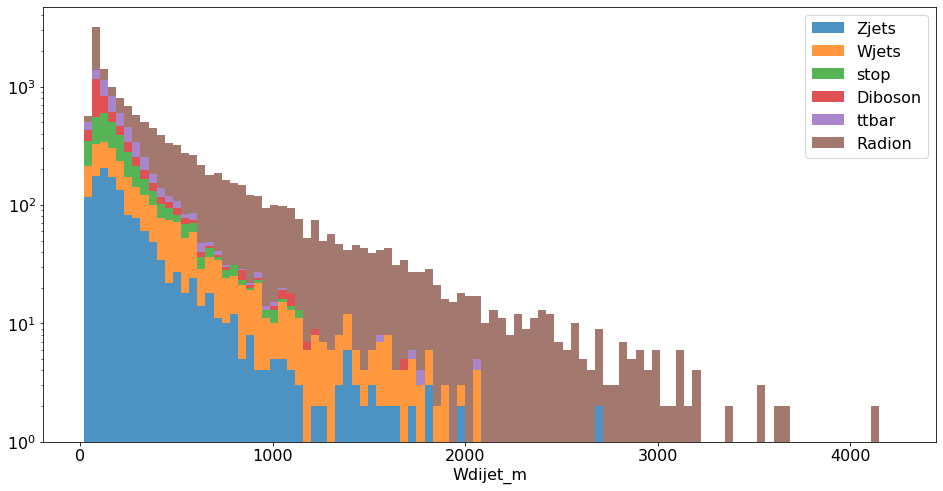

Wdijet_pt
Sampling Wdijet_pt in Zjets
Created  Wdijet_pt  array for  Zjets collection
Sampling Wdijet_pt in Wjets
Created  Wdijet_pt  array for  Wjets collection
Sampling Wdijet_pt in stop
Created  Wdijet_pt  array for  stop collection
Sampling Wdijet_pt in Diboson
Created  Wdijet_pt  array for  Diboson collection
Sampling Wdijet_pt in ttbar
Created  Wdijet_pt  array for  ttbar collection
Sampling Wdijet_pt in RSG
Created  Wdijet_pt  array for  RSG collection
Done


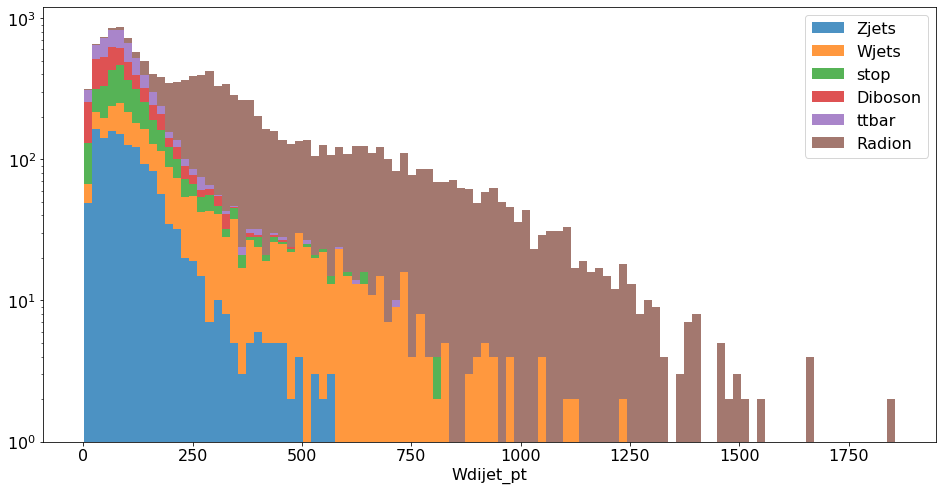

Wdijet_eta
Sampling Wdijet_eta in Zjets
Created  Wdijet_eta  array for  Zjets collection
Sampling Wdijet_eta in Wjets
Created  Wdijet_eta  array for  Wjets collection
Sampling Wdijet_eta in stop
Created  Wdijet_eta  array for  stop collection
Sampling Wdijet_eta in Diboson
Created  Wdijet_eta  array for  Diboson collection
Sampling Wdijet_eta in ttbar
Created  Wdijet_eta  array for  ttbar collection
Sampling Wdijet_eta in RSG
Created  Wdijet_eta  array for  RSG collection
Done


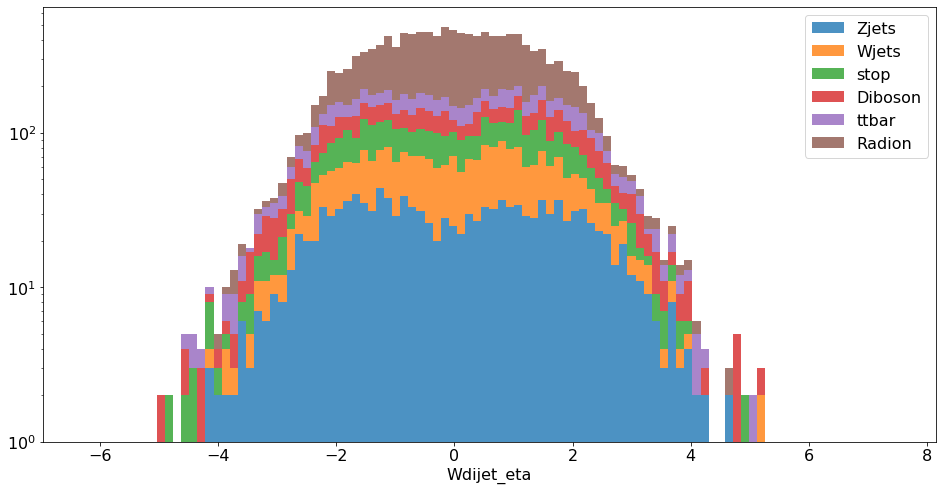

Wdijet_phi
Sampling Wdijet_phi in Zjets
Created  Wdijet_phi  array for  Zjets collection
Sampling Wdijet_phi in Wjets
Created  Wdijet_phi  array for  Wjets collection
Sampling Wdijet_phi in stop
Created  Wdijet_phi  array for  stop collection
Sampling Wdijet_phi in Diboson
Created  Wdijet_phi  array for  Diboson collection
Sampling Wdijet_phi in ttbar
Created  Wdijet_phi  array for  ttbar collection
Sampling Wdijet_phi in RSG
Created  Wdijet_phi  array for  RSG collection
Done


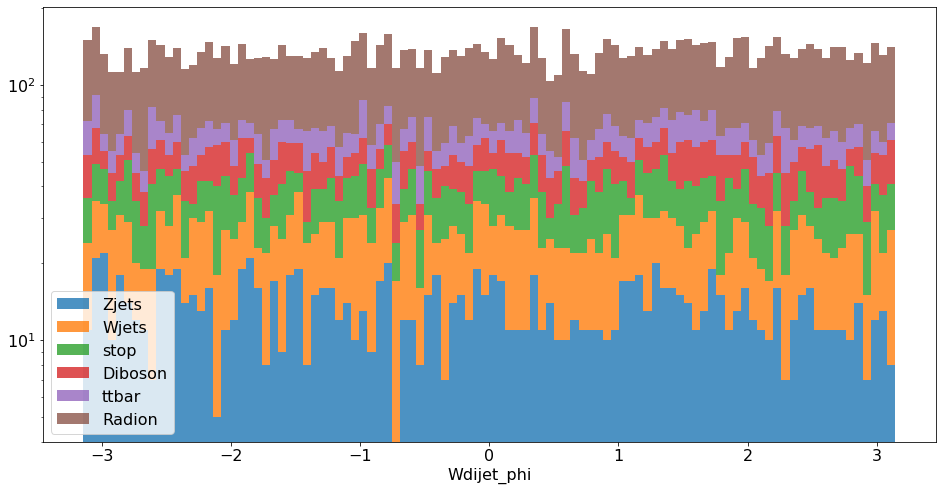

Zdijet_m
Sampling Zdijet_m in Zjets
Created  Zdijet_m  array for  Zjets collection
Sampling Zdijet_m in Wjets
Created  Zdijet_m  array for  Wjets collection
Sampling Zdijet_m in stop
Created  Zdijet_m  array for  stop collection
Sampling Zdijet_m in Diboson
Created  Zdijet_m  array for  Diboson collection
Sampling Zdijet_m in ttbar
Created  Zdijet_m  array for  ttbar collection
Sampling Zdijet_m in RSG
Created  Zdijet_m  array for  RSG collection
Done


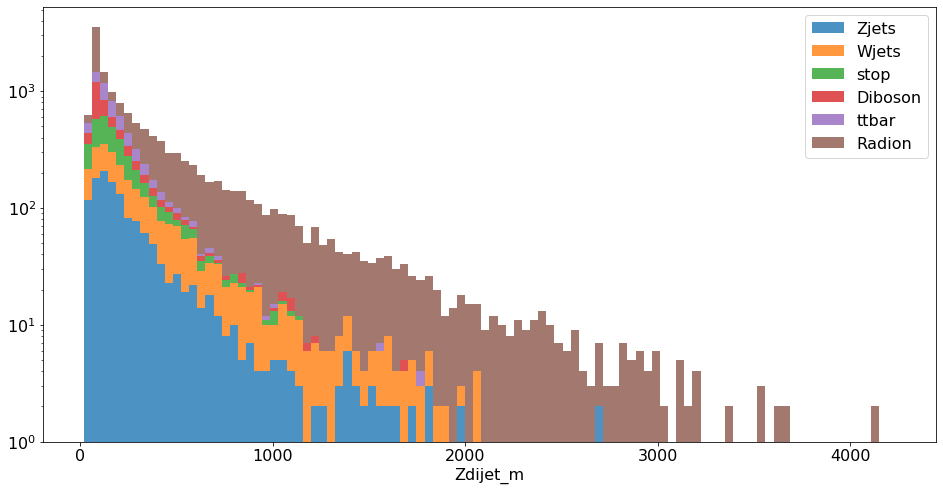

Zdijet_pt
Sampling Zdijet_pt in Zjets
Created  Zdijet_pt  array for  Zjets collection
Sampling Zdijet_pt in Wjets
Created  Zdijet_pt  array for  Wjets collection
Sampling Zdijet_pt in stop
Created  Zdijet_pt  array for  stop collection
Sampling Zdijet_pt in Diboson
Created  Zdijet_pt  array for  Diboson collection
Sampling Zdijet_pt in ttbar
Created  Zdijet_pt  array for  ttbar collection
Sampling Zdijet_pt in RSG
Created  Zdijet_pt  array for  RSG collection
Done


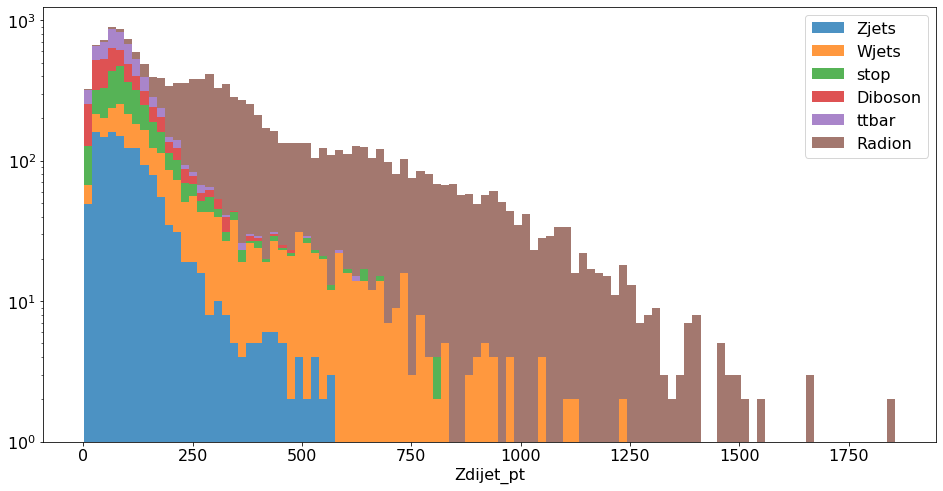

Zdijet_eta
Sampling Zdijet_eta in Zjets
Created  Zdijet_eta  array for  Zjets collection
Sampling Zdijet_eta in Wjets
Created  Zdijet_eta  array for  Wjets collection
Sampling Zdijet_eta in stop
Created  Zdijet_eta  array for  stop collection
Sampling Zdijet_eta in Diboson
Created  Zdijet_eta  array for  Diboson collection
Sampling Zdijet_eta in ttbar
Created  Zdijet_eta  array for  ttbar collection
Sampling Zdijet_eta in RSG
Created  Zdijet_eta  array for  RSG collection
Done


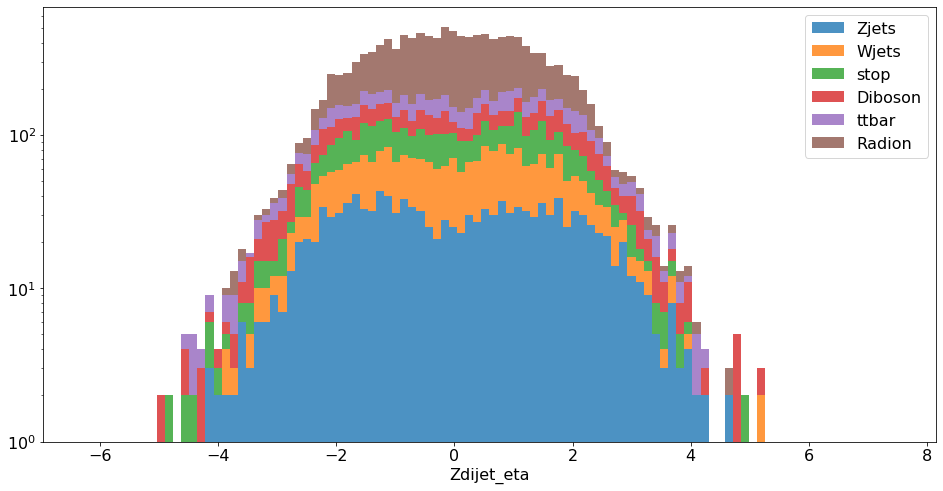

Zdijet_phi
Sampling Zdijet_phi in Zjets
Created  Zdijet_phi  array for  Zjets collection
Sampling Zdijet_phi in Wjets
Created  Zdijet_phi  array for  Wjets collection
Sampling Zdijet_phi in stop
Created  Zdijet_phi  array for  stop collection
Sampling Zdijet_phi in Diboson
Created  Zdijet_phi  array for  Diboson collection
Sampling Zdijet_phi in ttbar
Created  Zdijet_phi  array for  ttbar collection
Sampling Zdijet_phi in RSG
Created  Zdijet_phi  array for  RSG collection
Done


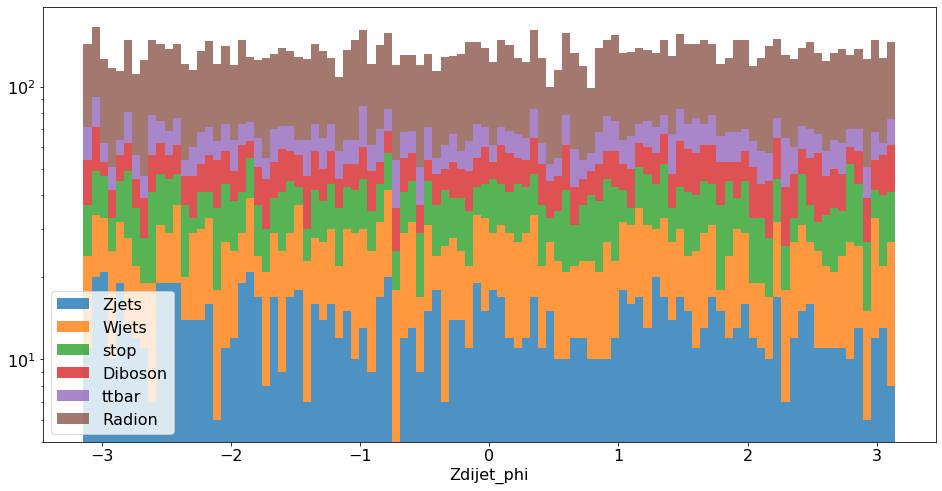

sigWJ1_m
Sampling sigWJ1_m in Zjets
Created  sigWJ1_m  array for  Zjets collection
Sampling sigWJ1_m in Wjets
Created  sigWJ1_m  array for  Wjets collection
Sampling sigWJ1_m in stop
Created  sigWJ1_m  array for  stop collection
Sampling sigWJ1_m in Diboson
Created  sigWJ1_m  array for  Diboson collection
Sampling sigWJ1_m in ttbar
Created  sigWJ1_m  array for  ttbar collection
Sampling sigWJ1_m in RSG
Created  sigWJ1_m  array for  RSG collection
Done


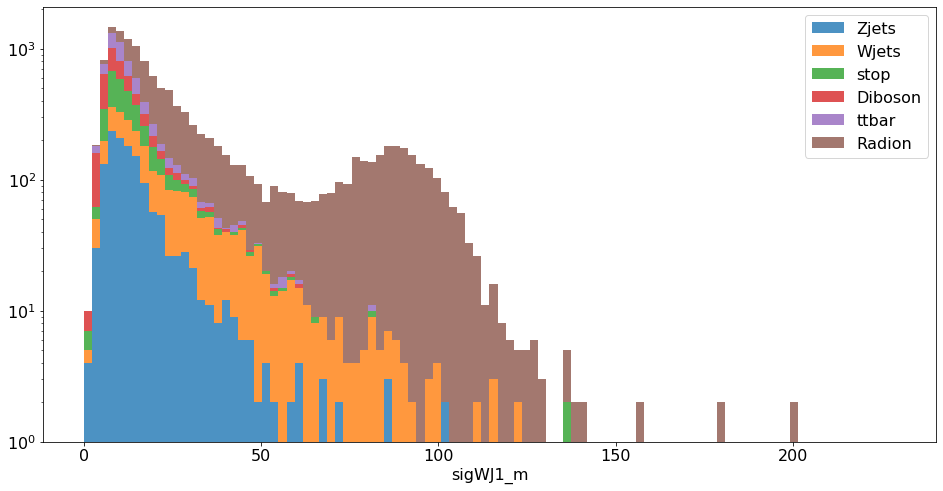

sigWJ1_pt
Sampling sigWJ1_pt in Zjets
Created  sigWJ1_pt  array for  Zjets collection
Sampling sigWJ1_pt in Wjets
Created  sigWJ1_pt  array for  Wjets collection
Sampling sigWJ1_pt in stop
Created  sigWJ1_pt  array for  stop collection
Sampling sigWJ1_pt in Diboson
Created  sigWJ1_pt  array for  Diboson collection
Sampling sigWJ1_pt in ttbar
Created  sigWJ1_pt  array for  ttbar collection
Sampling sigWJ1_pt in RSG
Created  sigWJ1_pt  array for  RSG collection
Done


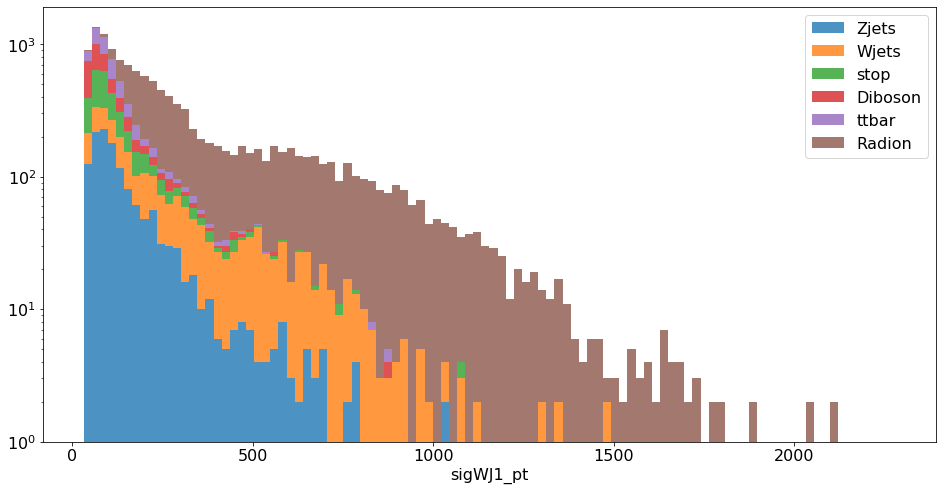

sigWJ1_eta
Sampling sigWJ1_eta in Zjets
Created  sigWJ1_eta  array for  Zjets collection
Sampling sigWJ1_eta in Wjets
Created  sigWJ1_eta  array for  Wjets collection
Sampling sigWJ1_eta in stop
Created  sigWJ1_eta  array for  stop collection
Sampling sigWJ1_eta in Diboson
Created  sigWJ1_eta  array for  Diboson collection
Sampling sigWJ1_eta in ttbar
Created  sigWJ1_eta  array for  ttbar collection
Sampling sigWJ1_eta in RSG
Created  sigWJ1_eta  array for  RSG collection
Done


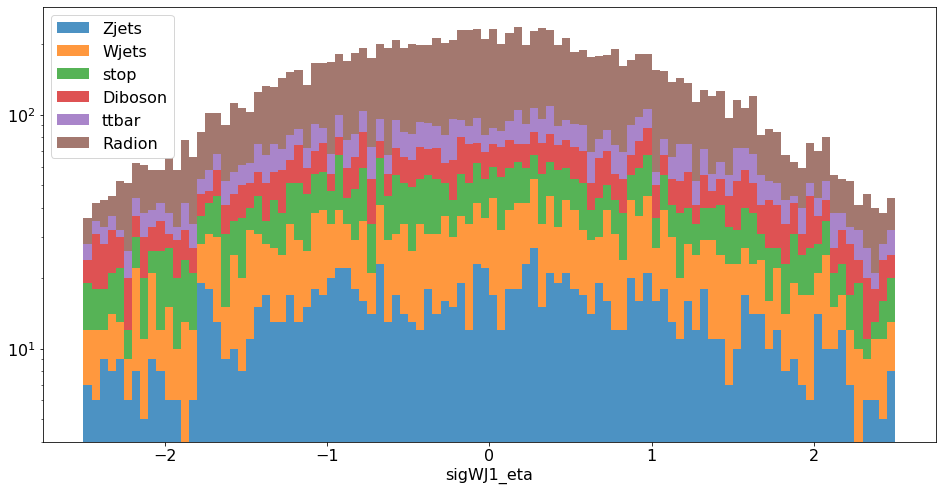

sigWJ1_phi
Sampling sigWJ1_phi in Zjets
Created  sigWJ1_phi  array for  Zjets collection
Sampling sigWJ1_phi in Wjets
Created  sigWJ1_phi  array for  Wjets collection
Sampling sigWJ1_phi in stop
Created  sigWJ1_phi  array for  stop collection
Sampling sigWJ1_phi in Diboson
Created  sigWJ1_phi  array for  Diboson collection
Sampling sigWJ1_phi in ttbar
Created  sigWJ1_phi  array for  ttbar collection
Sampling sigWJ1_phi in RSG
Created  sigWJ1_phi  array for  RSG collection
Done


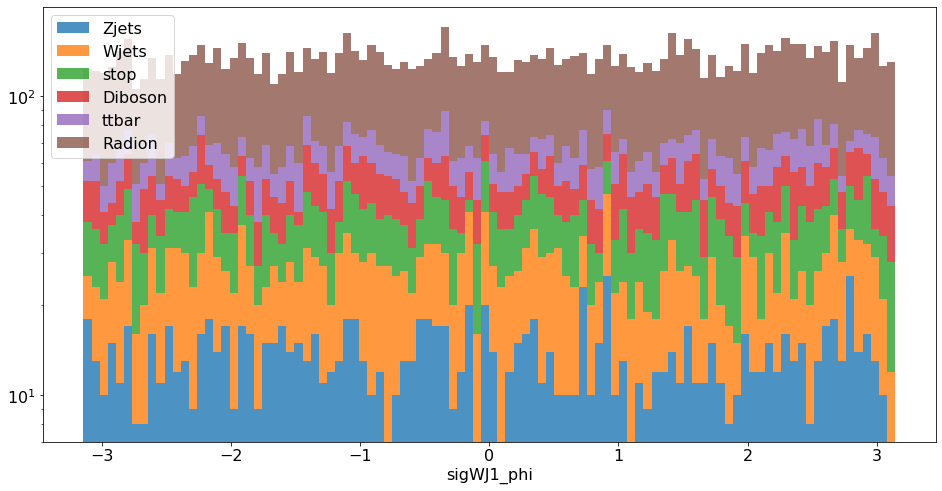

sigWJ2_m
Sampling sigWJ2_m in Zjets
Created  sigWJ2_m  array for  Zjets collection
Sampling sigWJ2_m in Wjets
Created  sigWJ2_m  array for  Wjets collection
Sampling sigWJ2_m in stop
Created  sigWJ2_m  array for  stop collection
Sampling sigWJ2_m in Diboson
Created  sigWJ2_m  array for  Diboson collection
Sampling sigWJ2_m in ttbar
Created  sigWJ2_m  array for  ttbar collection
Sampling sigWJ2_m in RSG
Created  sigWJ2_m  array for  RSG collection
Done


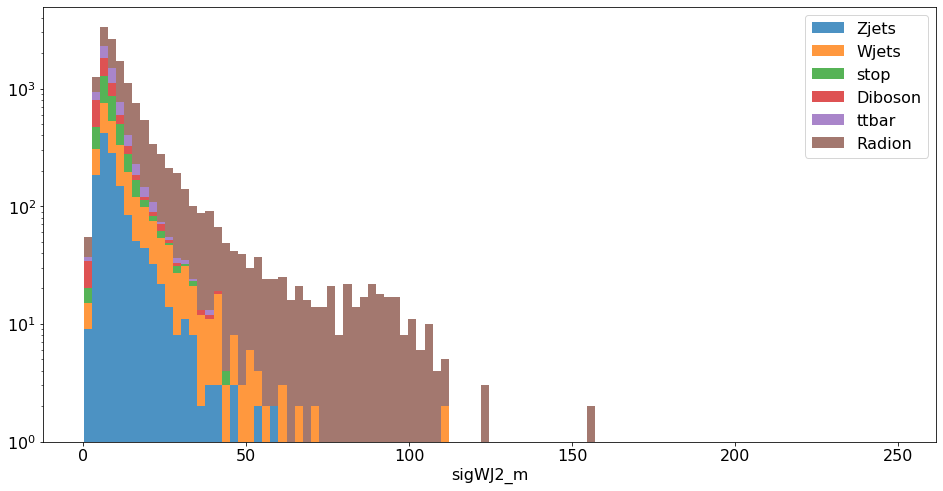

sigWJ2_pt
Sampling sigWJ2_pt in Zjets
Created  sigWJ2_pt  array for  Zjets collection
Sampling sigWJ2_pt in Wjets
Created  sigWJ2_pt  array for  Wjets collection
Sampling sigWJ2_pt in stop
Created  sigWJ2_pt  array for  stop collection
Sampling sigWJ2_pt in Diboson
Created  sigWJ2_pt  array for  Diboson collection
Sampling sigWJ2_pt in ttbar
Created  sigWJ2_pt  array for  ttbar collection
Sampling sigWJ2_pt in RSG
Created  sigWJ2_pt  array for  RSG collection
Done


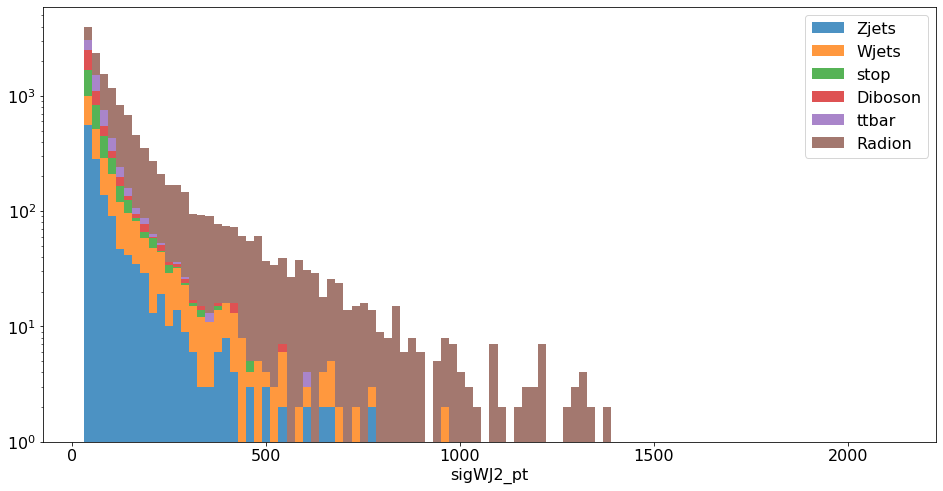

sigWJ2_eta
Sampling sigWJ2_eta in Zjets
Created  sigWJ2_eta  array for  Zjets collection
Sampling sigWJ2_eta in Wjets
Created  sigWJ2_eta  array for  Wjets collection
Sampling sigWJ2_eta in stop
Created  sigWJ2_eta  array for  stop collection
Sampling sigWJ2_eta in Diboson
Created  sigWJ2_eta  array for  Diboson collection
Sampling sigWJ2_eta in ttbar
Created  sigWJ2_eta  array for  ttbar collection
Sampling sigWJ2_eta in RSG
Created  sigWJ2_eta  array for  RSG collection
Done


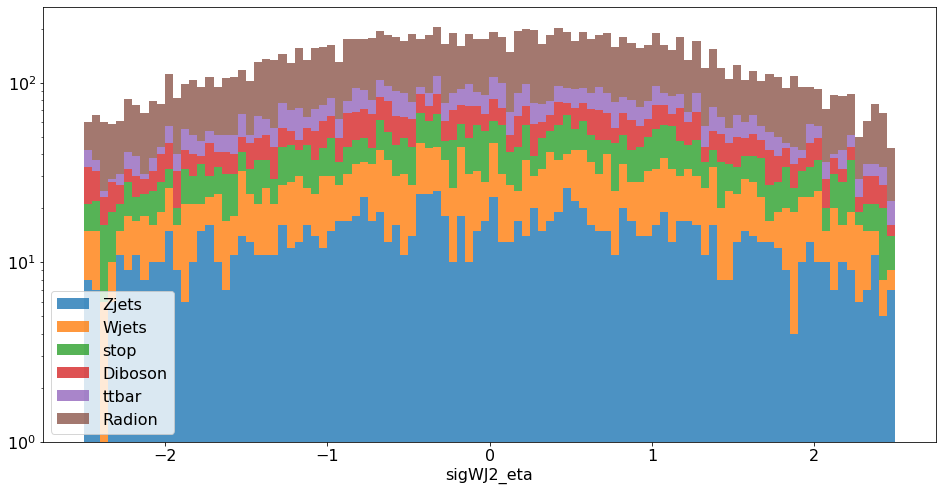

sigWJ2_phi
Sampling sigWJ2_phi in Zjets
Created  sigWJ2_phi  array for  Zjets collection
Sampling sigWJ2_phi in Wjets
Created  sigWJ2_phi  array for  Wjets collection
Sampling sigWJ2_phi in stop
Created  sigWJ2_phi  array for  stop collection
Sampling sigWJ2_phi in Diboson
Created  sigWJ2_phi  array for  Diboson collection
Sampling sigWJ2_phi in ttbar
Created  sigWJ2_phi  array for  ttbar collection
Sampling sigWJ2_phi in RSG
Created  sigWJ2_phi  array for  RSG collection
Done


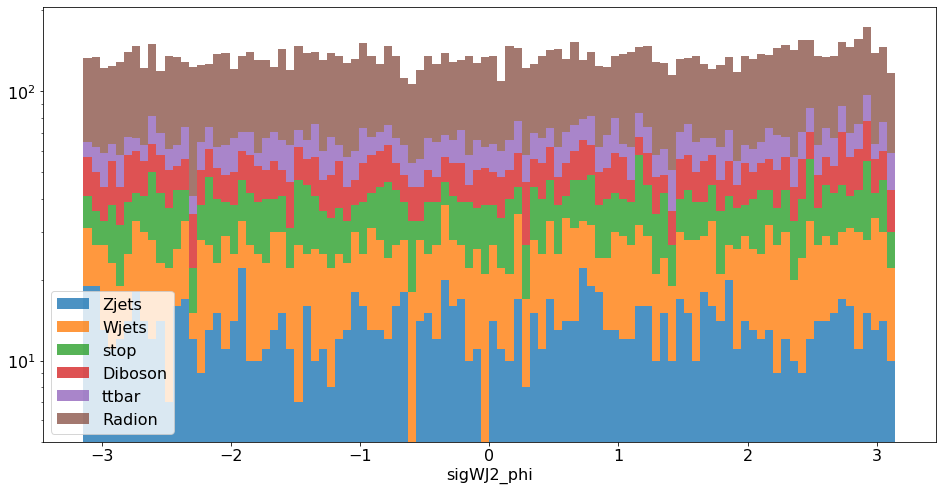

sigZJ1_m
Sampling sigZJ1_m in Zjets
Created  sigZJ1_m  array for  Zjets collection
Sampling sigZJ1_m in Wjets
Created  sigZJ1_m  array for  Wjets collection
Sampling sigZJ1_m in stop
Created  sigZJ1_m  array for  stop collection
Sampling sigZJ1_m in Diboson
Created  sigZJ1_m  array for  Diboson collection
Sampling sigZJ1_m in ttbar
Created  sigZJ1_m  array for  ttbar collection
Sampling sigZJ1_m in RSG
Created  sigZJ1_m  array for  RSG collection
Done


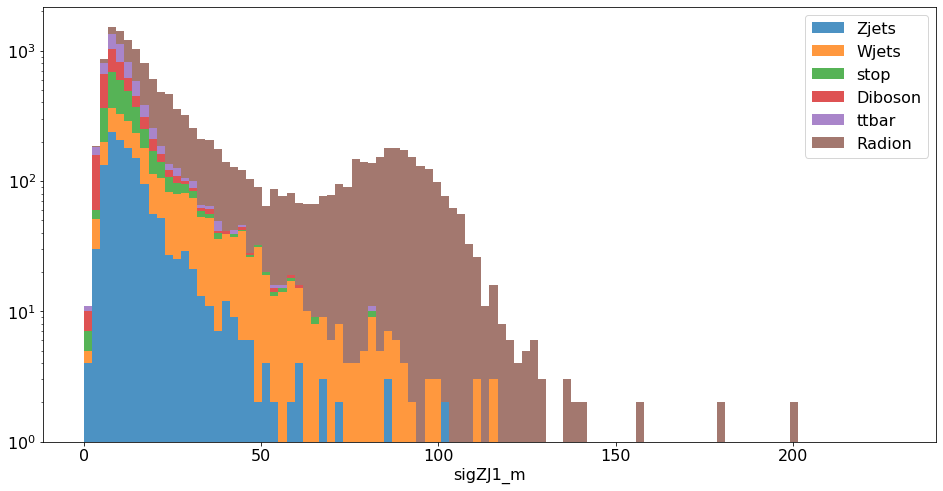

sigZJ1_pt
Sampling sigZJ1_pt in Zjets
Created  sigZJ1_pt  array for  Zjets collection
Sampling sigZJ1_pt in Wjets
Created  sigZJ1_pt  array for  Wjets collection
Sampling sigZJ1_pt in stop
Created  sigZJ1_pt  array for  stop collection
Sampling sigZJ1_pt in Diboson
Created  sigZJ1_pt  array for  Diboson collection
Sampling sigZJ1_pt in ttbar
Created  sigZJ1_pt  array for  ttbar collection
Sampling sigZJ1_pt in RSG
Created  sigZJ1_pt  array for  RSG collection
Done


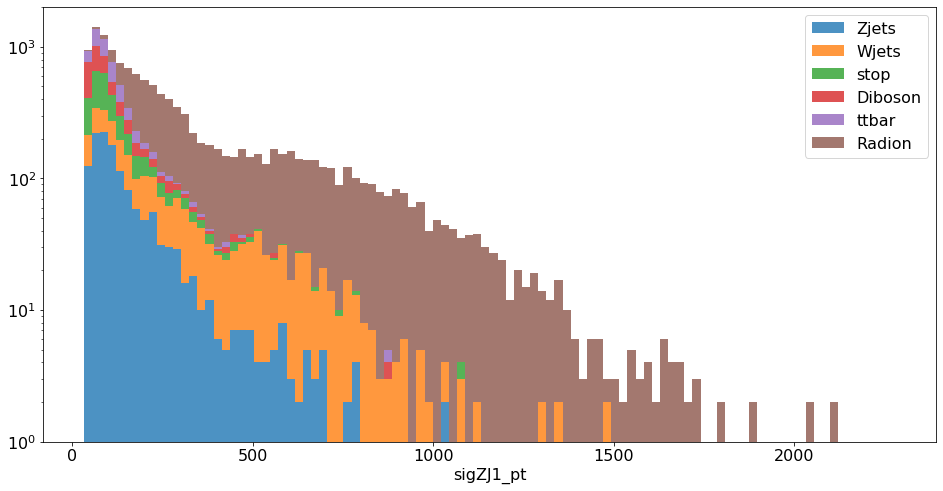

sigZJ1_eta
Sampling sigZJ1_eta in Zjets
Created  sigZJ1_eta  array for  Zjets collection
Sampling sigZJ1_eta in Wjets
Created  sigZJ1_eta  array for  Wjets collection
Sampling sigZJ1_eta in stop
Created  sigZJ1_eta  array for  stop collection
Sampling sigZJ1_eta in Diboson
Created  sigZJ1_eta  array for  Diboson collection
Sampling sigZJ1_eta in ttbar
Created  sigZJ1_eta  array for  ttbar collection
Sampling sigZJ1_eta in RSG
Created  sigZJ1_eta  array for  RSG collection
Done


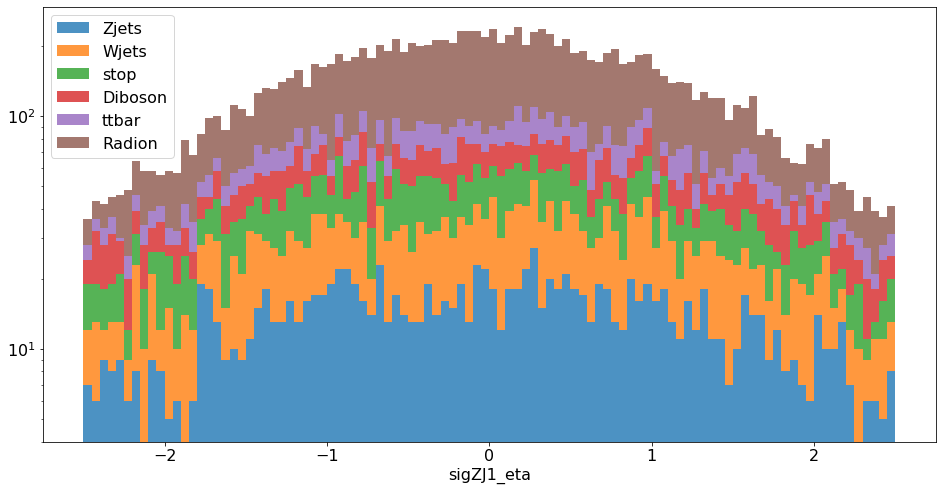

sigZJ1_phi
Sampling sigZJ1_phi in Zjets
Created  sigZJ1_phi  array for  Zjets collection
Sampling sigZJ1_phi in Wjets
Created  sigZJ1_phi  array for  Wjets collection
Sampling sigZJ1_phi in stop
Created  sigZJ1_phi  array for  stop collection
Sampling sigZJ1_phi in Diboson
Created  sigZJ1_phi  array for  Diboson collection
Sampling sigZJ1_phi in ttbar
Created  sigZJ1_phi  array for  ttbar collection
Sampling sigZJ1_phi in RSG
Created  sigZJ1_phi  array for  RSG collection
Done


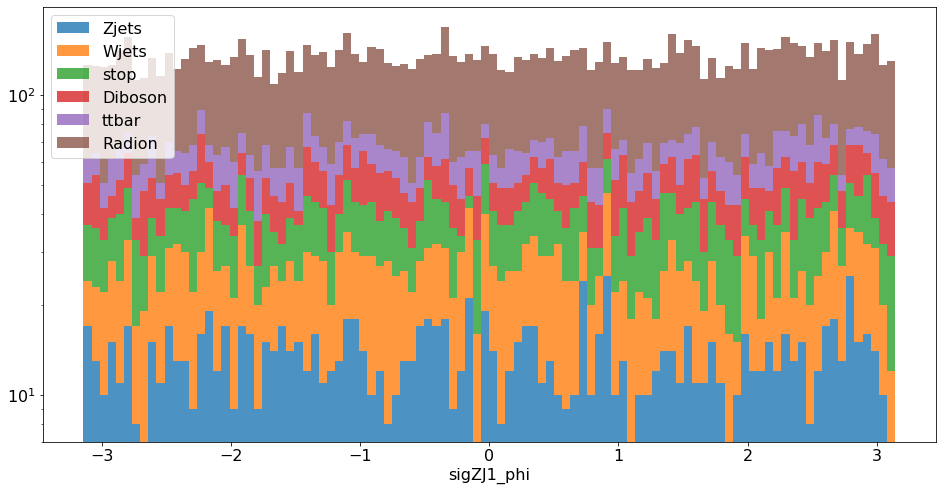

sigZJ2_m
Sampling sigZJ2_m in Zjets
Created  sigZJ2_m  array for  Zjets collection
Sampling sigZJ2_m in Wjets
Created  sigZJ2_m  array for  Wjets collection
Sampling sigZJ2_m in stop
Created  sigZJ2_m  array for  stop collection
Sampling sigZJ2_m in Diboson
Created  sigZJ2_m  array for  Diboson collection
Sampling sigZJ2_m in ttbar
Created  sigZJ2_m  array for  ttbar collection
Sampling sigZJ2_m in RSG
Created  sigZJ2_m  array for  RSG collection
Done


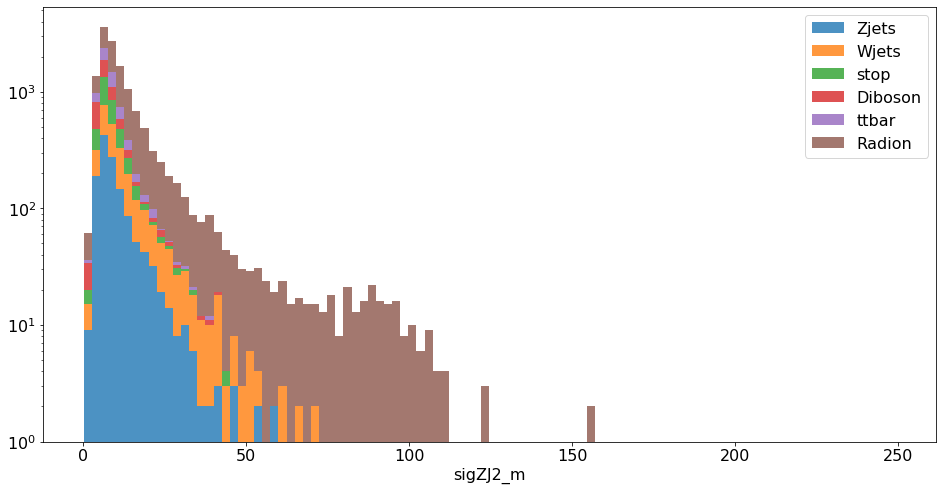

sigZJ2_pt
Sampling sigZJ2_pt in Zjets
Created  sigZJ2_pt  array for  Zjets collection
Sampling sigZJ2_pt in Wjets
Created  sigZJ2_pt  array for  Wjets collection
Sampling sigZJ2_pt in stop
Created  sigZJ2_pt  array for  stop collection
Sampling sigZJ2_pt in Diboson
Created  sigZJ2_pt  array for  Diboson collection
Sampling sigZJ2_pt in ttbar
Created  sigZJ2_pt  array for  ttbar collection
Sampling sigZJ2_pt in RSG
Created  sigZJ2_pt  array for  RSG collection
Done


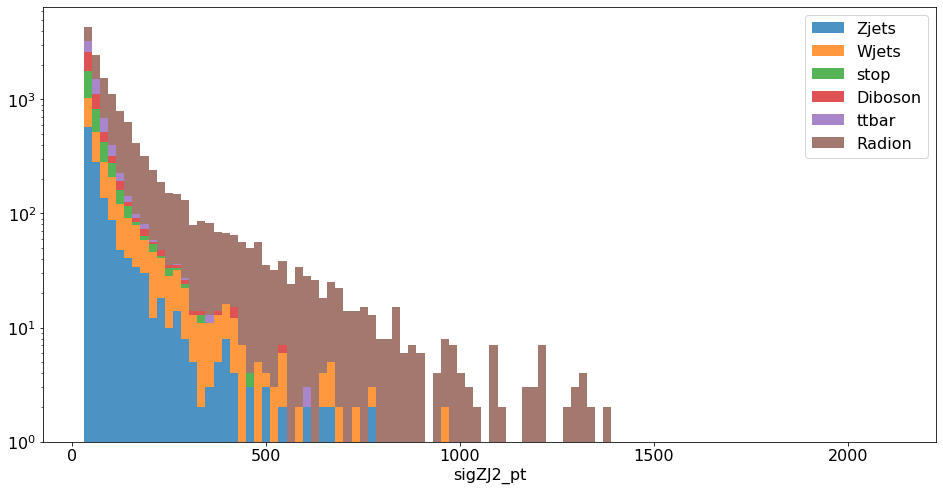

sigZJ2_eta
Sampling sigZJ2_eta in Zjets
Created  sigZJ2_eta  array for  Zjets collection
Sampling sigZJ2_eta in Wjets
Created  sigZJ2_eta  array for  Wjets collection
Sampling sigZJ2_eta in stop
Created  sigZJ2_eta  array for  stop collection
Sampling sigZJ2_eta in Diboson
Created  sigZJ2_eta  array for  Diboson collection
Sampling sigZJ2_eta in ttbar
Created  sigZJ2_eta  array for  ttbar collection
Sampling sigZJ2_eta in RSG
Created  sigZJ2_eta  array for  RSG collection
Done


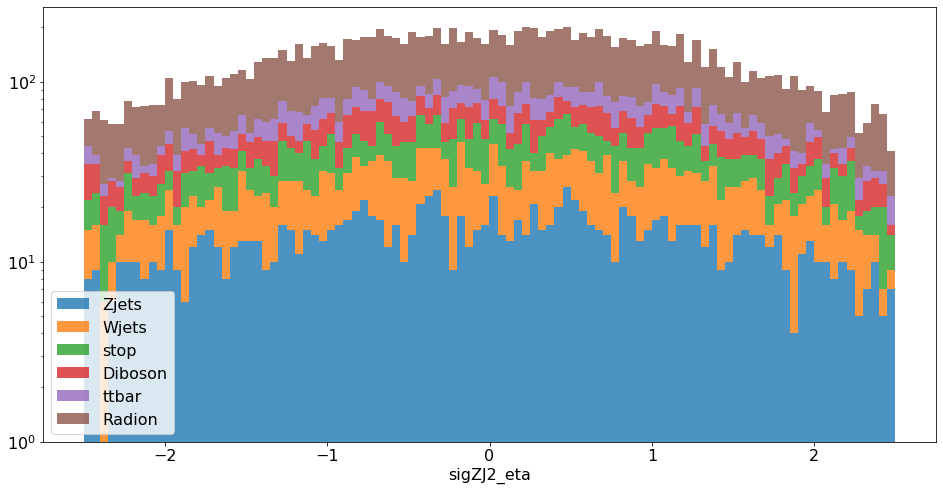

sigZJ2_phi
Sampling sigZJ2_phi in Zjets
Created  sigZJ2_phi  array for  Zjets collection
Sampling sigZJ2_phi in Wjets
Created  sigZJ2_phi  array for  Wjets collection
Sampling sigZJ2_phi in stop
Created  sigZJ2_phi  array for  stop collection
Sampling sigZJ2_phi in Diboson
Created  sigZJ2_phi  array for  Diboson collection
Sampling sigZJ2_phi in ttbar
Created  sigZJ2_phi  array for  ttbar collection
Sampling sigZJ2_phi in RSG
Created  sigZJ2_phi  array for  RSG collection
Done


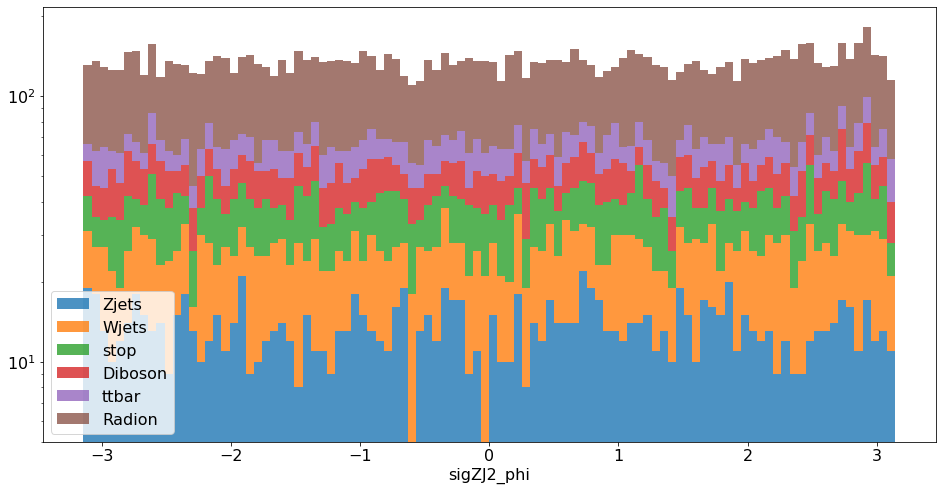

NJets
Sampling NJets in Zjets
Created  NJets  array for  Zjets collection
Sampling NJets in Wjets
Created  NJets  array for  Wjets collection
Sampling NJets in stop
Created  NJets  array for  stop collection
Sampling NJets in Diboson
Created  NJets  array for  Diboson collection
Sampling NJets in ttbar
Created  NJets  array for  ttbar collection
Sampling NJets in RSG
Created  NJets  array for  RSG collection
Done


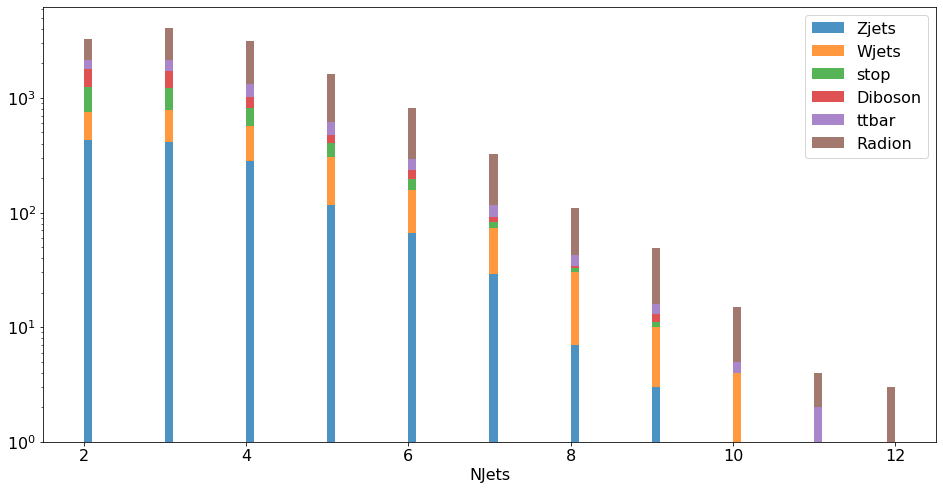

DSID
Sampling DSID in Zjets
Created  DSID  array for  Zjets collection
Sampling DSID in Wjets
Created  DSID  array for  Wjets collection
Sampling DSID in stop
Created  DSID  array for  stop collection
Sampling DSID in Diboson
Created  DSID  array for  Diboson collection
Sampling DSID in ttbar
Created  DSID  array for  ttbar collection
Sampling DSID in RSG
Created  DSID  array for  RSG collection
Done


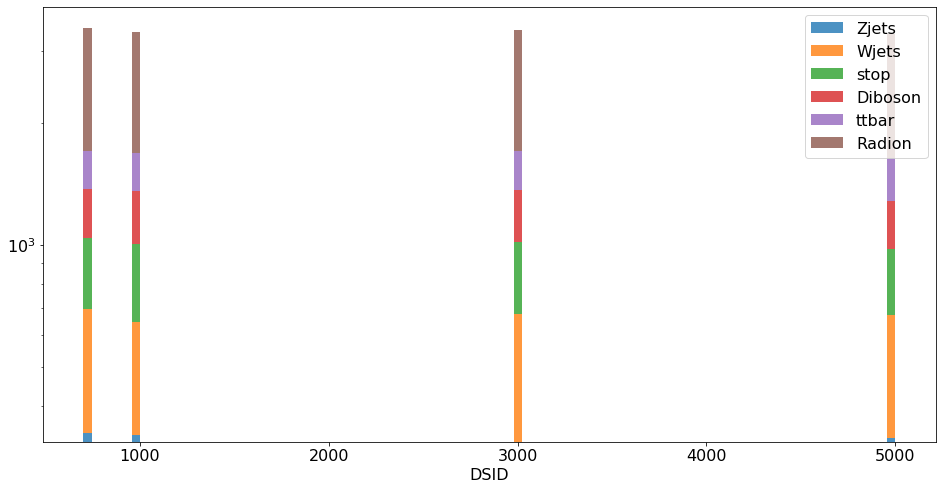

origin
Sampling origin in Zjets
Created  origin  array for  Zjets collection
Sampling origin in Wjets
Created  origin  array for  Wjets collection
Sampling origin in stop
Created  origin  array for  stop collection
Sampling origin in Diboson
Created  origin  array for  Diboson collection
Sampling origin in ttbar
Created  origin  array for  ttbar collection
Sampling origin in RSG
Created  origin  array for  RSG collection
Done


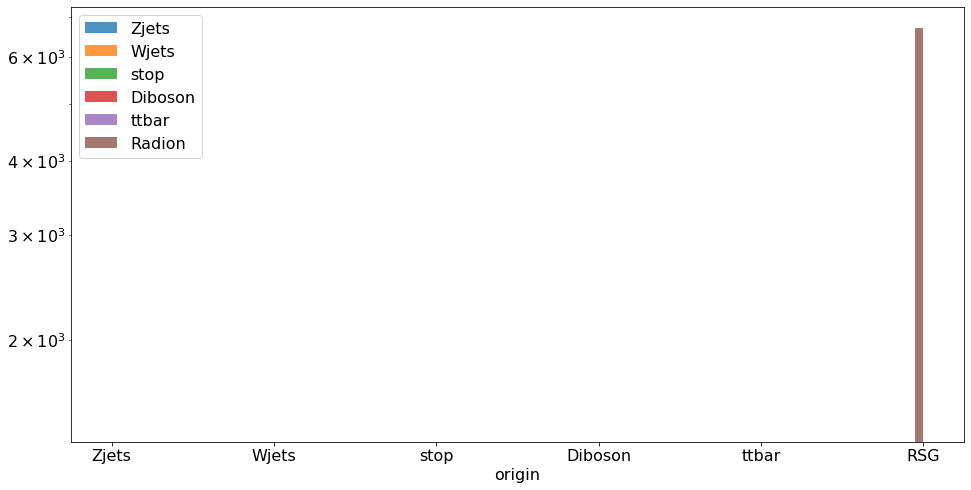

In [253]:
for var_str in dataVariables:
    print(var_str)
    l_var_df=mkplots.list_var_df(reweighted_dataset,var_str,training_samples)

    x_size=np.array([])
    x_l_var=np.array(l_var_df)
    for i in range(0,len(x_l_var)):
        x_size=np.append(x_size,x_l_var[i].shape[0])

    l_var_df=x_l_var[np.argsort(x_size)]
    plot_var(l_var_df,np.array(samples)[np.argsort(x_size)],var_str,'','','')
